## Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!gdown 1dQ7dqVnBfp4STYMVsnkiLfiAIdFwrSkd # Training data


Downloading...
From: https://drive.google.com/uc?id=1dQ7dqVnBfp4STYMVsnkiLfiAIdFwrSkd
To: /content/training_data.zip
100% 1.52G/1.52G [00:16<00:00, 94.4MB/s]


In [3]:
!gdown 1YedVnk4uKFBPInsa6Mzik0bmZK2Vuf4e # Target label data

Downloading...
From: https://drive.google.com/uc?id=1YedVnk4uKFBPInsa6Mzik0bmZK2Vuf4e
To: /content/train_gt.txt
100% 2.79M/2.79M [00:00<00:00, 166MB/s]


In [4]:
!unzip -q /content/training_data.zip

warning [/content/training_data.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [/content/training_data.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #103001).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


In [5]:
import os
import cv2
import torch

## Transform

In [6]:
import os
import random
from PIL import Image
import numpy as np
import albumentations as A
import PIL
class Enhance:
    def __init__(self):
        pass
    def __call__(self, img, mag=-1, p=1.):
        if np.random.uniform(0,1) > p:
            return img

        c = [.1, .7, 1.3]
        if mag<0 or mag>=len(c):
            index = np.random.randint(0, len(c))
        else:
            index = mag
        c = c[index]
        magnitude = np.random.uniform(c, c+.6)
        img = PIL.ImageEnhance.Sharpness(img).enhance(magnitude)
        img = PIL.ImageOps.autocontrast(img)
        return img

class ConcatAug:
    def __init__(self,height=64,img_dir=None,target_dir=None) -> None:
        self.height = height
        self.img_dir = img_dir
        self.list_img_dir = os.listdir(img_dir)

        with open(target_dir,"r",encoding="utf-8") as f:
            data = f.read()
        new_data = list(map(lambda i:i.split("\t"),data.split("\n")))
        if new_data[-1][0]=="":
            new_data.pop(-1)

        self.target_dict   = {x[0]:x[1]for x in new_data}
    def generate(self):
        d1,d2 = random.choice(self.list_img_dir), random.choice(self.list_img_dir)
        img_1 = np.asarray(Image.open(os.path.join(self.img_dir,d1)).convert("L"))
        img_2 = np.asarray(Image.open(os.path.join(self.img_dir,d2)).convert("L"))
        h1,w1 = img_1.shape
        h2,w2 = img_2.shape
        h = min(h1,h2)
        new_img_1 = cv2.resize(img_1,(int(h/h1*w1),h))
        new_img_2 = cv2.resize(img_2,(int(h/h2*w2),h))
        new_img   =  np.concatenate((new_img_1,new_img_2),axis=1)
        new_img = cv2.resize(new_img,(256,64))
        # new_img = self.pad(image=new_img)['image']
        # new_img = self.rotate(image=new_img)['image']
        new_img = np.expand_dims(new_img , axis = 2)
        new_img = np.concatenate([new_img, new_img, new_img], axis=2)
        target = self.target_dict[d1] + self.target_dict[d2]
        return new_img, target

cat_aug = ConcatAug(height=64,img_dir="/content/new_train",target_dir="/content/train_gt.txt")


## Run


In [7]:
num_gen = 20_000
SAVE_PATH = "/content/new_train"
with open("/content/train_gt.txt","r",encoding="utf-8") as f:
    data = f.read()
target_list = list(data.split("\n"))
for idx in range(num_gen):
    img_path = f"gen_img_{idx}.jpg"
    img,target = cat_aug.generate()
    cv2.imwrite(f"{SAVE_PATH}/{img_path}",img)
    target_list.append(f"{img_path}\t{target}")

In [8]:
!zip -r '/content/drive/MyDrive/DATA_OCR/123k/training_data.zip' '/content/new_train'

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  adding: content/new_train/train_img_46161.jpg (deflated 8%)
  adding: content/new_train/train_img_93141.png (deflated 9%)
  adding: content/new_train/train_img_52651.png (deflated 3%)
  adding: content/new_train/train_img_48030.jpg (deflated 7%)
  adding: content/new_train/train_img_38711.jpg (deflated 4%)
  adding: content/new_train/train_img_69072.png (deflated 9%)
  adding: content/new_train/train_img_101913.jpg (stored 0%)
  adding: content/new_train/train_img_94479.png (deflated 9%)
  adding: content/new_train/train_img_76135.png (deflated 11%)
  adding: content/new_train/train_img_94572.png (deflated 3%)
  adding: content/new_train/gen_img_13751.jpg (deflated 4%)
  adding: content/new_train/train_img_16013.jpg (deflated 3%)
  adding: content/new_train/gen_img_2099.jpg (deflated 3%)
  adding: content/new_train/train_img_54658.png (deflated 2%)
  adding: content/new_train/train_img_20784.jpg (deflated 8%)
  adding: content/

In [9]:
with open("/content/drive/MyDrive/DATA_OCR/123k/train_gt.txt", "w") as f:
    for d in target_list:
        f.write(d + "\n")

In [10]:
len(os.listdir("/content/new_train"))

123000

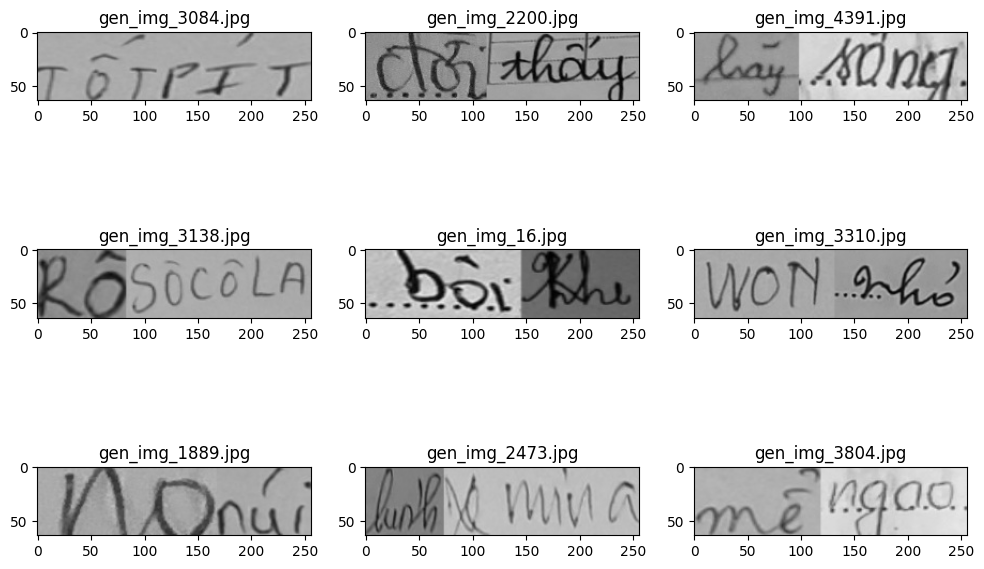

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
for i in range(9):
  idx = np.random.choice(5000)
  plt.subplot(3,3,i+1)
  plt.title(f"gen_img_{idx}.jpg")
  plt.imshow(Image.open(f"/content/new_train/gen_img_{idx}.jpg"))

In [12]:
len(target_list)

123000

In [13]:
with open("/content/drive/MyDrive/DATA_OCR/train_gt.txt","r") as f:
    data = f.read()
new_data = list(map(lambda i:i.split("\t"),data.split("\n")))